In [1]:
import os
import random
os.chdir(r"/home/xavient/koodo_survey")
import string
import re
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth',100)
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from textblob import Word
stopwords = nltk.corpus.stopwords.words('english')
seed = 42

In [2]:
rawdata = pd.read_excel('customer_verbatim_OMNI___clean_.xlsx')

In [3]:
data = rawdata.copy()

In [4]:
len(data)

168294

In [5]:
data.head()

,Respondent Id,MCX_ID,Line of Business,Agent Department Code (MU),Support level 4 (VP),Support level 4 TID (VP),Support level 3 (Director),Support level 3 TID (Director),Support level 2 (Ops Mgr),Support level 2 TID (Ops Mgr),...,Source label,Source date,Source ID,"B7_1. Agent (CSR) Performance Regarding the last call centre representative who assisted you, how would you rate their performan","Please share any comments you have regarding AGENT_FIRST_NAME, the SURVEY_BRAND customer service/Channel Care representative who assisted you.",Communicated clearly,Were willing to help,Treated me as a valued customer,Respected my time,Had the knowledge to respond to my inquiries
0,3524374,37364015008,Mobility,KDO_CR1_CELL300_TIE,LR,810410.0,DL,875189.0,MB,135951.0,...,INTERACTION_ID,20171229.0,706901562,Good,NaN,NaN,NaN,NaN,NaN,NaN
1,3524372,37364014950,Mobility,KDO_CR1_CELL300_TIE,LR,810410.0,DL,875189.0,JC,167206.0,...,INTERACTION_ID,20171229.0,706711123,Excellent,He was very helpful and polite.,NaN,NaN,NaN,NaN,NaN
2,3524371,37364014873,Mobility,KDO_TS_CELL300_TIE,LR,810410.0,DL,875189.0,MB,135951.0,...,INTERACTION_ID,20171229.0,706719963,Excellent,Helpful,NaN,NaN,NaN,NaN,NaN
3,3524367,37364014106,Mobility,KDO_CR1_CELL300_TIE,NaN,NaN,NaN,NaN,GP,146069.0,...,INTERACTION_ID,20171229.0,706835893,Very good,NaN,NaN,NaN,NaN,NaN,NaN
4,3524363,37364013496,Mobility,KDO_CR2_CELL300_TIE,LR,810410.0,DL,875189.0,JC,167206.0,...,INTERACTION_ID,20171229.0,706908437,Good,None. I spent almost 2hrs on the phone to resolve an issue and all I received was a credit of $...,NaN,NaN,NaN,NaN,NaN


In [6]:
data.shape

(168294, 29)

In [7]:
data.columns=['Respondent_Id', 'MCX_ID', 'Line_of_Business',
       'Agent_Department_Code_MU', 'Support_level_4_VP',
       'Support_level_4_TID_VP', 'Support_level_3_Director',
       'Support_level_3_TID_Director', 'Support_level_2_Ops_Mgr',
       'Support_level_2_TID_Ops_Mgr', 'Support_level_1_Team_Mgr',
       'Support_level_1_TID_Team_Mgr', 'Agent_Full_Name', 'Agent_ID',
       'Survey_Medium', 'Survey_Integrity_Hidden', 'COMPLETED_DATE',
       'Completed_Date', 'Source_database', 'Source_label', 'Source_date',
       'Source_ID','B7_1_Agent_CSR','Feedback',
       'Communicated_clearly', 'Were_willing_to_help',
       'Treated_me_as_a_valued_customer', 'Respected_my_time',
       'Had_the_knowledge_to_respond_to_my_inquiries']

In [8]:
object_columns = data.columns

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168294 entries, 0 to 168293
Data columns (total 29 columns):
Respondent_Id                                   168294 non-null int64
MCX_ID                                          168294 non-null int64
Line_of_Business                                168290 non-null object
Agent_Department_Code_MU                        168294 non-null object
Support_level_4_VP                              165450 non-null object
Support_level_4_TID_VP                          165450 non-null float64
Support_level_3_Director                        165450 non-null object
Support_level_3_TID_Director                    165501 non-null float64
Support_level_2_Ops_Mgr                         167459 non-null object
Support_level_2_TID_Ops_Mgr                     168270 non-null float64
Support_level_1_Team_Mgr                        168141 non-null object
Support_level_1_TID_Team_Mgr                    168294 non-null int64
Agent_Full_Name                      

In [10]:
# type casting to object
for column in object_columns:
    if data[column].dtypes=="int64":
        data[column] = data[column].astype('str')
    elif data[column].dtypes=="float64":
        data[column] = data[column].astype('str')

In [11]:
# select unique identifier
print(data.shape[0])
print(len(data['Respondent_Id'].unique()))
print(len(data['MCX_ID'].unique()))

168294
168294
168294


In [12]:
# set index for customer identification code
data = data.drop(['MCX_ID'],axis=1)
object_columns = data.columns

In [13]:
object_columns

Index(['Respondent_Id', 'Line_of_Business', 'Agent_Department_Code_MU',
       'Support_level_4_VP', 'Support_level_4_TID_VP',
       'Support_level_3_Director', 'Support_level_3_TID_Director',
       'Support_level_2_Ops_Mgr', 'Support_level_2_TID_Ops_Mgr',
       'Support_level_1_Team_Mgr', 'Support_level_1_TID_Team_Mgr',
       'Agent_Full_Name', 'Agent_ID', 'Survey_Medium',
       'Survey_Integrity_Hidden', 'COMPLETED_DATE', 'Completed_Date',
       'Source_database', 'Source_label', 'Source_date', 'Source_ID',
       'B7_1_Agent_CSR', 'Feedback', 'Communicated_clearly',
       'Were_willing_to_help', 'Treated_me_as_a_valued_customer',
       'Respected_my_time', 'Had_the_knowledge_to_respond_to_my_inquiries'],
      dtype='object')

In [14]:
data = data.drop(['Line_of_Business','Agent_Full_Name','Agent_ID','COMPLETED_DATE','Completed_Date','Source_date','Source_ID',
                        'Source_label','Source_database','Survey_Integrity_Hidden','Support_level_4_TID_VP',
                        'Support_level_3_TID_Director','Support_level_2_TID_Ops_Mgr','Support_level_1_TID_Team_Mgr'],axis=1)

In [15]:
data = data[data['Feedback'].str.len() > 1] ## this also includes spaces

In [16]:
data = data[data['B7_1_Agent_CSR']!='Excellent'] ## this also includes spaces
#data = data[data['Communicated_clearly']!='Excellent'] ## this also includes spaces
#data = data[data['Were_willing_to_help']!='Excellent'] ## this also includes spaces
#data = data[data['Treated_me_as_a_valued_customer']!='Excellent'] ## this also includes spaces
#data = data[data['Respected_my_time']!='Excellent'] ## this also includes spaces
data = data[data['Had_the_knowledge_to_respond_to_my_inquiries']!='Excellent'] ## this also includes spaces

In [17]:
data.shape

(42368, 14)

In [18]:
# view levels per columns in the non-continious variable
object_columns = data.columns
for column in object_columns:
    print(column)
    print(data[column].unique())

Respondent_Id
['3524363' '3524290' '3524253' ... '1708641' '1708640' '1708635']
Agent_Department_Code_MU
['KDO_CR2_CELL300_TIE' 'KDO_CR1_CELL300_TIE' 'KDO_TS_CELL300_TIE'
 'MOB_KDPRE_CARE_ENG_TIE' 'MOB_PMTECHENG_TIE' 'MOB_PMCARENG_TIE'
 'MOB_KDPRE_CARE_FRE_TIE' 'MOB_PMCARFRE_TIE' 'MOB_KDATMENG_TIE'
 'MOB_KDCART_TIE' 'MOB_KDCARENG_TIE' 'MOB_KDCARFRE_TIE']
Support_level_4_VP
['LR' nan 'KS']
Support_level_3_Director
['DL' nan 'KI']
Support_level_2_Ops_Mgr
['JC' 'MB' 'JB' 'JL' 'GP' 'BC' 'NM' 'AM' 'JA' 'AA' 'CM' 'SN' 'GB' nan 'IM'
 'AG' 'JCA']
Support_level_1_Team_Mgr
['JFCM' 'RA' 'ER' 'JAVT' 'MMG' 'GIPR' 'JSLM' 'EL' 'GERA' 'RHSS' 'CRAC'
 'TL' 'ERLE' 'JAA' 'GGRR' 'CGMG' 'DEMT' 'KMHP' 'MAHR' 'LAGH' 'AEZC' 'FC'
 'LMCC' 'LAA' 'AEFV' 'NEMR' 'AN' 'MJSS' 'LBRP' 'ROAH' 'MLME' 'MAJS' nan
 'JJMD' 'JM' 'JL' 'MJ' 'FdCCV' 'AJNM' 'GR' 'NM' 'CV' 'MI' 'MV' 'AB' 'AD'
 'MAN' 'LD' 'GI' 'AS' 'ABG' 'EC' 'IMS' 'IC' 'DLC' 'AG' 'NMMO' 'GB' 'AEMT'
 'DA']
Survey_Medium
['SMS' 'Email_short' 'Email_long']
B7_1_Agent_

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42368 entries, 4 to 168284
Data columns (total 14 columns):
Respondent_Id                                   42368 non-null object
Agent_Department_Code_MU                        42368 non-null object
Support_level_4_VP                              41629 non-null object
Support_level_3_Director                        41629 non-null object
Support_level_2_Ops_Mgr                         42150 non-null object
Support_level_1_Team_Mgr                        42316 non-null object
Survey_Medium                                   42368 non-null object
B7_1_Agent_CSR                                  42366 non-null object
Feedback                                        42368 non-null object
Communicated_clearly                            11023 non-null object
Were_willing_to_help                            10894 non-null object
Treated_me_as_a_valued_customer                 10981 non-null object
Respected_my_time                               10

In [20]:
checkdata = data[data['Feedback'].notnull()]
checkdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42368 entries, 4 to 168284
Data columns (total 14 columns):
Respondent_Id                                   42368 non-null object
Agent_Department_Code_MU                        42368 non-null object
Support_level_4_VP                              41629 non-null object
Support_level_3_Director                        41629 non-null object
Support_level_2_Ops_Mgr                         42150 non-null object
Support_level_1_Team_Mgr                        42316 non-null object
Survey_Medium                                   42368 non-null object
B7_1_Agent_CSR                                  42366 non-null object
Feedback                                        42368 non-null object
Communicated_clearly                            11023 non-null object
Were_willing_to_help                            10894 non-null object
Treated_me_as_a_valued_customer                 10981 non-null object
Respected_my_time                               10

In [21]:
checkdata.head()

,Respondent_Id,Agent_Department_Code_MU,Support_level_4_VP,Support_level_3_Director,Support_level_2_Ops_Mgr,Support_level_1_Team_Mgr,Survey_Medium,B7_1_Agent_CSR,Feedback,Communicated_clearly,Were_willing_to_help,Treated_me_as_a_valued_customer,Respected_my_time,Had_the_knowledge_to_respond_to_my_inquiries
4,3524363,KDO_CR2_CELL300_TIE,LR,DL,JC,JFCM,SMS,Good,None. I spent almost 2hrs on the phone to resolve an issue and all I received was a credit of $...,NaN,NaN,NaN,NaN,NaN
12,3524290,KDO_CR1_CELL300_TIE,LR,DL,MB,RA,SMS,Very good,The rep was pleasant and helpful,NaN,NaN,NaN,NaN,NaN
17,3524253,KDO_CR1_CELL300_TIE,LR,DL,MB,ER,SMS,Very good,Thanking her for the 100 mb.,NaN,NaN,NaN,NaN,NaN
23,3524187,KDO_CR1_CELL300_TIE,LR,DL,JB,JAVT,SMS,Poor,Might not been all his fault. The system he has to work with is out of date. Took too long on ...,NaN,NaN,NaN,NaN,NaN
31,3524107,KDO_CR1_CELL300_TIE,NaN,NaN,JL,MMG,SMS,Very good,sure was good.. but the wait,NaN,NaN,NaN,NaN,NaN


In [22]:
# Training
#checkdata = checkdata[checkdata['Communicated_clearly'].notnull()]
#checkdata = checkdata[checkdata['Treated_me_as_a_valued_customer'].notnull()]
#checkdata = checkdata[checkdata['Were_willing_to_help'].notnull()]
#checkdata = checkdata[checkdata['Respected_my_time'].notnull()]
checkdata = checkdata[checkdata['Had_the_knowledge_to_respond_to_my_inquiries'].notnull()]
checkdata = checkdata.drop(['Communicated_clearly','Treated_me_as_a_valued_customer','Were_willing_to_help',
                            'Respected_my_time'],axis=1)

In [23]:
# Training
#checkdata['Communicated_clearly'].value_counts()
#checkdata['Respected_my_time'].value_counts()
#checkdata['Treated_me_as_a_valued_customer'].value_counts()
#checkdata['Were_willing_to_help'].value_counts()
checkdata['Had_the_knowledge_to_respond_to_my_inquiries'].value_counts()

Very good    4699
Good         2684
Poor         1662
Fair         1411
Name: Had_the_knowledge_to_respond_to_my_inquiries, dtype: int64

In [24]:
# Training

#checkdata_verygood = checkdata[checkdata['Had_the_knowledge_to_respond_to_my_inquiries']=='Very good'].sample(1411)
#checkdata_good = checkdata[checkdata['Had_the_knowledge_to_respond_to_my_inquiries']=='Good'].sample(1411)
#checkdata_fair = checkdata[checkdata['Had_the_knowledge_to_respond_to_my_inquiries']=='Fair'].sample(1411)
#checkdata_poor = checkdata[checkdata['Had_the_knowledge_to_respond_to_my_inquiries']=='Poor'].sample(1411)


In [25]:
# Training
#checkdata = pd.concat([checkdata_verygood,checkdata_good,checkdata_fair,checkdata_poor],axis=0)
#checkdata.shape

In [26]:
checkdata['B7_1_Agent_CSR'].value_counts()

Very good    5070
Good         2526
Poor         1537
Fair         1321
Name: B7_1_Agent_CSR, dtype: int64

In [27]:
checkdata['Had_the_knowledge_to_respond_to_my_inquiries'].value_counts()

Very good    4699
Good         2684
Poor         1662
Fair         1411
Name: Had_the_knowledge_to_respond_to_my_inquiries, dtype: int64

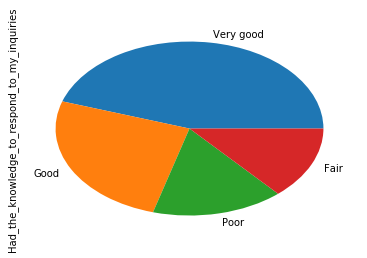

In [28]:
# Training
checkdata['Had_the_knowledge_to_respond_to_my_inquiries'].value_counts().plot('pie')
plt.show()

In [29]:
#pd.crosstab(checkdata['B7_1_Agent_CSR'],checkdata['Communicated_clearly'])

In [30]:
#pd.crosstab(checkdata['B7_1_Agent_CSR'],checkdata['Were_willing_to_help'])

In [31]:
#pd.crosstab(checkdata['B7_1_Agent_CSR'],checkdata['Treated_me_as_a_valued_customer'])

In [32]:
#pd.crosstab(checkdata['B7_1_Agent_CSR'],checkdata['Respected_my_time'])

In [33]:
pd.crosstab(checkdata['B7_1_Agent_CSR'],checkdata['Had_the_knowledge_to_respond_to_my_inquiries'])


Had_the_knowledge_to_respond_to_my_inquiries,Fair,Good,Poor,Very good
B7_1_Agent_CSR,,,,
Fair,567,320,331,103
Good,457,1298,140,631
Poor,230,116,1143,48
Very good,156,949,48,3917


In [34]:
checkdata['is_mins'] = checkdata['Feedback'].apply(lambda x: " ".join(x.lower() for x in x.split())).str.contains('mins')
checkdata['is_minute'] = checkdata['Feedback'].apply(lambda x: " ".join(x.lower() for x in x.split())).str.contains('minute')
checkdata['is_minutes'] = checkdata['Feedback'].apply(lambda x: " ".join(x.lower() for x in x.split())).str.contains('minutes')
checkdata['is_hour'] = checkdata['Feedback'].apply(lambda x: " ".join(x.lower() for x in x.split())).str.contains('hour')
checkdata['is_hours'] = checkdata['Feedback'].apply(lambda x: " ".join(x.lower() for x in x.split())).str.contains('hours')
checkdata['is_hrs'] = checkdata['Feedback'].apply(lambda x: " ".join(x.lower() for x in x.split())).str.contains('hrs')
checkdata['is_hr'] = checkdata['Feedback'].apply(lambda x: " ".join(x.lower() for x in x.split())).str.contains('hr')

In [35]:
checkdata['Feedback'] = checkdata['Feedback'].astype('str')

In [36]:
checkdata['char_count'] = np.log2(checkdata['Feedback'].str.len())#**2


In [37]:
checkdata['word_count'] = np.log2(checkdata['Feedback'].apply(lambda x: len((x).split(" "))))#**2

In [38]:
checkdata['numerics'] = np.log2(checkdata['Feedback'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))+1)#**2

In [39]:
checkdata['upper'] = np.log2(checkdata['Feedback'].apply(lambda x: len([x for x in x.split() if x.isupper()]))+1)#**2

In [40]:
def avg_word(text):
  words = (text).split()
  return (sum(len(word) for word in words)/len(words))

checkdata['avg_word'] = np.log2(checkdata['Feedback'].apply(lambda x: avg_word(x)))

In [41]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

checkdata['stopwords'] = np.log2(checkdata['Feedback'].apply(lambda x: len([x for x in x.split() if x in stop]))+1)#**2

In [42]:
import string
def count_punct(text):
    count = sum(1 for char in text if char in string.punctuation)
    return round(count/(len(text)-text.count(" ")),3)*100

checkdata['punc%'] = np.log2(checkdata['Feedback'].apply(lambda x: count_punct(x))+1)#**2

In [43]:
checkdata.head()

,Respondent_Id,Agent_Department_Code_MU,Support_level_4_VP,Support_level_3_Director,Support_level_2_Ops_Mgr,Support_level_1_Team_Mgr,Survey_Medium,B7_1_Agent_CSR,Feedback,Had_the_knowledge_to_respond_to_my_inquiries,...,is_hours,is_hrs,is_hr,char_count,word_count,numerics,upper,avg_word,stopwords,punc%
79,3523509,KDO_CR1_CELL300_TIE,NaN,NaN,JL,MMG,Email_short,Fair,She was polite and she tried. I just think the fine print in the plan I was calling about is/wa...,Poor,...,False,False,False,7.936638,5.584963,0.0,2.0,2.074768,4.459432,2.321928
89,3523102,KDO_CR2_CELL300_TIE,LR,DL,JC,EL,Email_short,Very good,Good rep,Very good,...,False,False,False,3.000000,1.000000,0.0,0.0,1.807355,0.000000,0.000000
90,3523089,KDO_CR1_CELL300_TIE,LR,DL,JC,RHSS,Email_short,Very good,"Friendly, helpful: a good experience",Very good,...,False,False,False,5.169925,2.321928,0.0,0.0,2.678072,1.000000,2.847997
91,3523082,KDO_CR1_CELL300_TIE,LR,DL,JC,CRAC,Email_short,Very good,All good.,Very good,...,False,False,False,3.169925,1.000000,0.0,0.0,2.000000,0.000000,3.754888
92,3523075,KDO_CR1_CELL300_TIE,NaN,NaN,GP,TL,Email_short,Very good,"I appreciate Carlos' help on the customer loyalty request, however, the Tab credits were not app...",Good,...,False,False,False,7.467606,4.954196,0.0,1.0,2.245476,3.700440,2.350497


In [44]:
checkdata['Feedback1'] = checkdata['Feedback'].apply(lambda x: " ".join(x.lower() for x in x.split()))
checkdata['Feedback1'] = checkdata['Feedback1'].str.replace('[^\w\s]','')
checkdata['Feedback1'] = checkdata['Feedback1'].apply(lambda x:''.join([x for x in x if not x.isdigit()]))
checkdata['Feedback1'] = checkdata['Feedback1'].apply(lambda x: " ".join(ps.stem(x) for x in x.split() if x not in stop))
#checkdata['Feedback1'] = checkdata['Feedback1'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#[ps.stem(word) for word in token if word not in stopwords]

In [45]:
checkdata[['Feedback','Feedback1']].tail(20)

,Feedback,Feedback1
168101,Good,good
168114,No comments,comment
168132,Thank u to help me with my questions,thank u help question
168141,He was able to help me turn my data on when it had been turned off incorrectly but could not tel...,abl help turn data turn incorrectli could tell chang screen say instead data havetold go koodo s...
168151,"Very polite, calm and patient. Did not fully understand my complaint at first it seemed but took...",polit calm patient fulli understand complaint first seem took time go usag data explain charg
168152,She was nice.,nice
168153,He was very good. Polite under standing.,good polit stand
168160,Friendly and helpful,friendli help
168178,Resolved my issue quickly and effectively so it was good. Just took a long time before my call w...,resolv issu quickli effect good took long time call answer
168200,first call......was put on hold for 1/2 hour. Then said a replacement phone would be sent during...,first callwa put hold hour said replac phone would sent servic phone phone sent also disappoint ...


In [46]:
#freq = pd.Series(' '.join(checkdata['Feedback1']).split()).value_counts()

In [47]:
#freq = pd.DataFrame(freq).to_csv("freq.csv")

In [48]:
#freq = pd.read_csv("freq.csv")
#freq.columns = ['word','tf']

In [49]:
tf1 = (checkdata['Feedback1']).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']


In [50]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(checkdata.shape[0]/(len(checkdata[checkdata['Feedback1'].str.contains(word)])))

In [51]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']

In [52]:
tf1.describe()

,tf,idf,tfidf
count,6821.000000,6821.000000,6821.000000
mean,15.618238,7.863426,65.683625
std,78.527605,1.855397,210.545055
min,1.000000,0.000000,0.000000
25%,1.000000,6.952346,9.254931
50%,1.000000,8.561784,9.254931
75%,4.000000,9.254931,31.474548
max,2431.000000,9.254931,3930.957718


In [53]:
#tf1['logtfidf'] = np.log(tf1['tfidf']+1)

In [54]:
#tf1['logtfidf'].plot('kde')

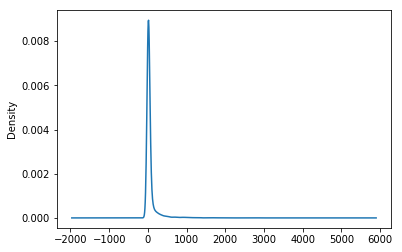

In [55]:
tf1['tfidf'].plot('kde')

In [56]:
tf1[tf1['tfidf'] > tf1['tfidf'].quantile(.25)].describe()

,tf,idf,tfidf
count,3036.000000,3036.000000,3036.000000
mean,33.754611,6.846284,136.658344
std,115.156643,1.674344,300.881406
min,2.000000,0.264614,9.381166
25%,3.000000,5.789195,18.509863
50%,5.000000,7.309021,38.227467
75%,18.000000,8.156319,109.169204
max,2431.000000,9.254931,3930.957718


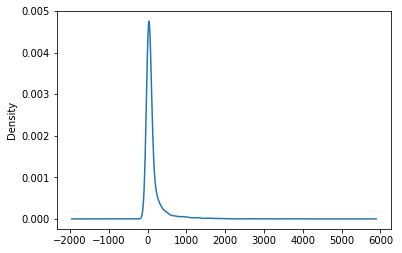

In [57]:
tf1['tfidf'][tf1['tfidf'] > tf1['tfidf'].quantile(.25)].plot('kde')

In [58]:
tf1 = tf1[tf1['tfidf'] > tf1['tfidf'].quantile(.25)]

In [59]:
tf1.describe()

,tf,idf,tfidf
count,3036.000000,3036.000000,3036.000000
mean,33.754611,6.846284,136.658344
std,115.156643,1.674344,300.881406
min,2.000000,0.264614,9.381166
25%,3.000000,5.789195,18.509863
50%,5.000000,7.309021,38.227467
75%,18.000000,8.156319,109.169204
max,2431.000000,9.254931,3930.957718


In [60]:
tf_keeplist = pd.DataFrame(list(tf1['words']))

In [61]:
tf_keeplist.to_csv("keepwordlist.csv")

In [62]:
tf_datframe = pd.read_csv("keepwordlist.csv")

In [63]:
tf_keeplist = list(tf_datframe.iloc[:,1])

In [64]:
checkdata['Feedback1'] = checkdata['Feedback1'].apply(lambda x: " ".join(x for x in x.split() if x in tf_keeplist))

In [65]:
checkdata.head()

,Respondent_Id,Agent_Department_Code_MU,Support_level_4_VP,Support_level_3_Director,Support_level_2_Ops_Mgr,Support_level_1_Team_Mgr,Survey_Medium,B7_1_Agent_CSR,Feedback,Had_the_knowledge_to_respond_to_my_inquiries,...,is_hrs,is_hr,char_count,word_count,numerics,upper,avg_word,stopwords,punc%,Feedback1
79,3523509,KDO_CR1_CELL300_TIE,NaN,NaN,JL,MMG,Email_short,Fair,She was polite and she tried. I just think the fine print in the plan I was calling about is/wa...,Poor,...,False,False,7.936638,5.584963,0.0,2.0,2.074768,4.459432,2.321928,polit tri think fine print plan call confus even didnt fulli understand couldnt explain logic wa...
89,3523102,KDO_CR2_CELL300_TIE,LR,DL,JC,EL,Email_short,Very good,Good rep,Very good,...,False,False,3.000000,1.000000,0.0,0.0,1.807355,0.000000,0.000000,good rep
90,3523089,KDO_CR1_CELL300_TIE,LR,DL,JC,RHSS,Email_short,Very good,"Friendly, helpful: a good experience",Very good,...,False,False,5.169925,2.321928,0.0,0.0,2.678072,1.000000,2.847997,friendli help good experi
91,3523082,KDO_CR1_CELL300_TIE,LR,DL,JC,CRAC,Email_short,Very good,All good.,Very good,...,False,False,3.169925,1.000000,0.0,0.0,2.000000,0.000000,3.754888,good
92,3523075,KDO_CR1_CELL300_TIE,NaN,NaN,GP,TL,Email_short,Very good,"I appreciate Carlos' help on the customer loyalty request, however, the Tab credits were not app...",Good,...,False,False,7.467606,4.954196,0.0,1.0,2.245476,3.700440,2.350497,appreci carlo help custom loyalti request howev tab credit appli line account pleas updat get ch...


In [66]:
def condition(rating):
#    if rating == 'Excellent':
#        return 0
    if rating == 'Very good':
        return 0
    elif rating == 'Good':
        return 0
    elif rating == 'Fair':
        return 1
    elif rating == 'Poor':
        return 1
    else:
        return "missing"

In [67]:
checkdata['target'] = checkdata['Had_the_knowledge_to_respond_to_my_inquiries'].apply(lambda x: condition(x))
#checkdata['B7_1_Agent_CSR'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: condition(x))
checkdata = checkdata.drop(['Had_the_knowledge_to_respond_to_my_inquiries'],axis=1)

In [68]:
checkdata.target.value_counts()

0    7383
1    3073
Name: target, dtype: int64

In [69]:
'''
checkdata['is_Excellent'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==0 else 0)
checkdata['is_Vgood'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==1 else 0)
checkdata['is_good'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==2 else 0)
checkdata['is_fair'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==3 else 0)
checkdata['is_poor'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==4 else 0)
checkdata = checkdata.drop(['B7_1_Agent_CSR'],axis=1)
'''

"\ncheckdata['is_Excellent'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==0 else 0)\ncheckdata['is_Vgood'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==1 else 0)\ncheckdata['is_good'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==2 else 0)\ncheckdata['is_fair'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==3 else 0)\ncheckdata['is_poor'] = checkdata['B7_1_Agent_CSR'].apply(lambda x: 1 if x==4 else 0)\ncheckdata = checkdata.drop(['B7_1_Agent_CSR'],axis=1)\n"

In [70]:
#cols = ['Feedback']  + [col for col in checkdata if col != 'Feedback']
#checkdata = checkdata[cols]

In [71]:
'''
# Training
from matplotlib import pyplot
%matplotlib inline
bins = np.linspace(0,200,40)
pyplot.hist(checkdata[checkdata['target']==0]['word_count'],bins,alpha=0.5, normed=True,label='bad')
pyplot.hist(checkdata[checkdata['target']==1]['word_count'],bins,alpha=0.5, normed=True,label='good')
pyplot.legend(loc='upper right')
pyplot.show()
'''

"\n# Training\nfrom matplotlib import pyplot\n%matplotlib inline\nbins = np.linspace(0,200,40)\npyplot.hist(checkdata[checkdata['target']==0]['word_count'],bins,alpha=0.5, normed=True,label='bad')\npyplot.hist(checkdata[checkdata['target']==1]['word_count'],bins,alpha=0.5, normed=True,label='good')\npyplot.legend(loc='upper right')\npyplot.show()\n"

In [72]:
'''# Training
from matplotlib import pyplot
%matplotlib inline
bins = np.linspace(0,800,40)
pyplot.hist(checkdata[checkdata['target']==0]['char_count'],bins,alpha=0.5, normed=True,label='bad')
pyplot.hist(checkdata[checkdata['target']==1]['char_count'],bins,alpha=0.5, normed=True,label='good')
pyplot.legend(loc='upper right')
pyplot.show()
'''

"# Training\nfrom matplotlib import pyplot\n%matplotlib inline\nbins = np.linspace(0,800,40)\npyplot.hist(checkdata[checkdata['target']==0]['char_count'],bins,alpha=0.5, normed=True,label='bad')\npyplot.hist(checkdata[checkdata['target']==1]['char_count'],bins,alpha=0.5, normed=True,label='good')\npyplot.legend(loc='upper right')\npyplot.show()\n"

In [73]:
'''# Training
from matplotlib import pyplot
%matplotlib inline
bins = np.linspace(0,10,40)
pyplot.hist(checkdata[checkdata['target']==0]['avg_word'],bins,alpha=0.5, normed=True,label='bad')
pyplot.hist(checkdata[checkdata['target']==1]['avg_word'],bins,alpha=0.5, normed=True,label='good')
pyplot.legend(loc='upper right')
pyplot.show()
'''

"# Training\nfrom matplotlib import pyplot\n%matplotlib inline\nbins = np.linspace(0,10,40)\npyplot.hist(checkdata[checkdata['target']==0]['avg_word'],bins,alpha=0.5, normed=True,label='bad')\npyplot.hist(checkdata[checkdata['target']==1]['avg_word'],bins,alpha=0.5, normed=True,label='good')\npyplot.legend(loc='upper right')\npyplot.show()\n"

In [74]:
'''# Training
from matplotlib import pyplot
%matplotlib inline
bins = np.linspace(0,100,40)
pyplot.hist(checkdata[checkdata['target']==0]['stopwords'],bins,alpha=0.5, normed=True,label='bad')
pyplot.hist(checkdata[checkdata['target']==1]['stopwords'],bins,alpha=0.5, normed=True,label='good')
pyplot.legend(loc='upper right')
pyplot.show()
'''

"# Training\nfrom matplotlib import pyplot\n%matplotlib inline\nbins = np.linspace(0,100,40)\npyplot.hist(checkdata[checkdata['target']==0]['stopwords'],bins,alpha=0.5, normed=True,label='bad')\npyplot.hist(checkdata[checkdata['target']==1]['stopwords'],bins,alpha=0.5, normed=True,label='good')\npyplot.legend(loc='upper right')\npyplot.show()\n"

In [75]:
'''# Training
from matplotlib import pyplot
%matplotlib inline
bins = np.linspace(0,20,40)
pyplot.hist(checkdata[checkdata['target']==0]['punc%'],bins,alpha=0.5,normed=True,label='bad')
pyplot.hist(checkdata[checkdata['target']==1]['punc%'],bins,alpha=0.5, normed=True,label='good')
pyplot.legend(loc='upper right')
pyplot.show()
'''

"# Training\nfrom matplotlib import pyplot\n%matplotlib inline\nbins = np.linspace(0,20,40)\npyplot.hist(checkdata[checkdata['target']==0]['punc%'],bins,alpha=0.5,normed=True,label='bad')\npyplot.hist(checkdata[checkdata['target']==1]['punc%'],bins,alpha=0.5, normed=True,label='good')\npyplot.legend(loc='upper right')\npyplot.show()\n"

In [76]:
'''# Training
from matplotlib import pyplot
%matplotlib inline
bins = np.linspace(0,15,40)
pyplot.hist(checkdata[checkdata['target']==0]['upper'],bins,alpha=0.5, normed=True,label='bad')
pyplot.hist(checkdata[checkdata['target']==1]['upper'],bins,alpha=0.5, normed=True,label='good')
pyplot.legend(loc='upper right')
pyplot.show()
'''

"# Training\nfrom matplotlib import pyplot\n%matplotlib inline\nbins = np.linspace(0,15,40)\npyplot.hist(checkdata[checkdata['target']==0]['upper'],bins,alpha=0.5, normed=True,label='bad')\npyplot.hist(checkdata[checkdata['target']==1]['upper'],bins,alpha=0.5, normed=True,label='good')\npyplot.legend(loc='upper right')\npyplot.show()\n"

In [77]:
checkdata.columns

Index(['Respondent_Id', 'Agent_Department_Code_MU', 'Support_level_4_VP',
       'Support_level_3_Director', 'Support_level_2_Ops_Mgr',
       'Support_level_1_Team_Mgr', 'Survey_Medium', 'B7_1_Agent_CSR',
       'Feedback', 'is_mins', 'is_minute', 'is_minutes', 'is_hour', 'is_hours',
       'is_hrs', 'is_hr', 'char_count', 'word_count', 'numerics', 'upper',
       'avg_word', 'stopwords', 'punc%', 'Feedback1', 'target'],
      dtype='object')

In [78]:
#!python -m spacy download en_core_web_lg

In [79]:
#import re
#checkdata['is_wait_true'] = checkdata.Feedback.contains('wait', regex=True)

In [80]:
checkdata = checkdata.drop(['Feedback'],axis=1)

In [81]:
checkdata.shape
all_obj_columns = checkdata.columns

In [82]:
checkdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10456 entries, 79 to 168271
Data columns (total 24 columns):
Respondent_Id               10456 non-null object
Agent_Department_Code_MU    10456 non-null object
Support_level_4_VP          10295 non-null object
Support_level_3_Director    10295 non-null object
Support_level_2_Ops_Mgr     10376 non-null object
Support_level_1_Team_Mgr    10435 non-null object
Survey_Medium               10456 non-null object
B7_1_Agent_CSR              10454 non-null object
is_mins                     10456 non-null bool
is_minute                   10456 non-null bool
is_minutes                  10456 non-null bool
is_hour                     10456 non-null bool
is_hours                    10456 non-null bool
is_hrs                      10456 non-null bool
is_hr                       10456 non-null bool
char_count                  10456 non-null float64
word_count                  10456 non-null float64
numerics                    10456 non-null float64


In [83]:
# missing value imputation strategy: create a new level called 'UNKNOWN'

for column in all_obj_columns:
    if checkdata[column].dtypes=="object":
        checkdata[column] = checkdata[column].fillna("UKNOWN").astype('object')

In [84]:
checkdata_notarget = checkdata.drop(['target'],axis=1)

In [85]:
all_obj_columns = checkdata_notarget.columns
all_obj_columns

Index(['Respondent_Id', 'Agent_Department_Code_MU', 'Support_level_4_VP',
       'Support_level_3_Director', 'Support_level_2_Ops_Mgr',
       'Support_level_1_Team_Mgr', 'Survey_Medium', 'B7_1_Agent_CSR',
       'is_mins', 'is_minute', 'is_minutes', 'is_hour', 'is_hours', 'is_hrs',
       'is_hr', 'char_count', 'word_count', 'numerics', 'upper', 'avg_word',
       'stopwords', 'punc%', 'Feedback1'],
      dtype='object')

In [86]:
# scale the numerical variables to bring the numerical variables to the same scale for fault tolerance
from sklearn.preprocessing import scale

for column in all_obj_columns:
    if checkdata[column].dtypes in ["int64","float64"] :
        checkdata[column] = scale(checkdata[column].astype('float64'))

In [87]:
checkdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10456 entries, 79 to 168271
Data columns (total 24 columns):
Respondent_Id               10456 non-null object
Agent_Department_Code_MU    10456 non-null object
Support_level_4_VP          10456 non-null object
Support_level_3_Director    10456 non-null object
Support_level_2_Ops_Mgr     10456 non-null object
Support_level_1_Team_Mgr    10456 non-null object
Survey_Medium               10456 non-null object
B7_1_Agent_CSR              10456 non-null object
is_mins                     10456 non-null bool
is_minute                   10456 non-null bool
is_minutes                  10456 non-null bool
is_hour                     10456 non-null bool
is_hours                    10456 non-null bool
is_hrs                      10456 non-null bool
is_hr                       10456 non-null bool
char_count                  10456 non-null float64
word_count                  10456 non-null float64
numerics                    10456 non-null float64


In [88]:
#from scipy import stats
#stats.ttest_ind(checkdata['char_count'], checkdata['target'])

In [89]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

/home/xavient/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [90]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(checkdata['Feedback1'])

In [91]:
tokenizer

In [92]:
import pickle
tokenizer_mytime1 = 'tokenizer.sav'
pickle.dump(tokenizer, open(tokenizer_mytime1, 'wb'))

In [93]:
tokenizer_mytime1 = pickle.load(open('tokenizer.sav', 'rb'))
#print("tokenizer loaded: ")# + str(result))

In [94]:
tokenizer_mytime1

In [95]:
sequences = tokenizer_mytime1.texts_to_sequences(checkdata['Feedback1'])
data = pad_sequences(sequences, maxlen=50)

In [101]:
labels = checkdata['target']

In [102]:
data.shape

(10456, 50)

In [103]:
model_lstm = Sequential()
model_lstm.add(Embedding(20000, 100, input_length=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='relu'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [104]:
#model_lstm.fit(data, np.array(labels), validation_split=0.4, epochs=3)

In [105]:
# model 4
#from sklearn.model_selection import train_test_split
#X_train6, X_test6, y_train6, y_test6 = train_test_split(data, labels, test_size = .3, random_state = seed)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = .4, random_state=seed)

# Using smote to increase the number of under-represented class
sm = SMOTE(random_state = 12, ratio = 'minority')

X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res.shape, y_train_res.shape, X_val.shape, y_val.shape

((8832, 50), (8832,), (4183, 50), (4183,))

In [ ]:
model_lstm.fit(X_train_res, y_train_res, validation_split=0.3, epochs=7, batch_size=32)

Train on 6182 samples, validate on 2650 samples
Epoch 1/7


In [ ]:
model_lstm.save('model_lstm.h5')
pickle.dump(history, open("history.p", "wb"))

model_lstm = load_model('model_lstm.h5')
history = pickle.load(open("history.p", "rb"))

In [ ]:
# serialize model to JSON
model_smote_json = model_lstm.model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_smote_json)
# serialize weights to HDF5
model_lstm.model.save_weights("model_json.h5")
print("Saved model to disk")

In [258]:
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
model_lstm.load_weights('model_json.h5')
#model_lstm.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#print("Loaded model from disk")

NameError: name 'model_from_json' is not defined

In [126]:
# import metrics for model evaluation
# Training
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix,classification_report,precision_score,roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score
#sklearn.metrics.cohen_kappa_score(y1, y2, labels=None, weights=None, sample_weight=None)
# create function to evaluate model performance

def evaluate_classes(model, X_test, y_test):
    y_pred = model.predict_classes(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    roc = roc_auc_score(y_test,y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_pred, sample_weight=None)
    #tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    #precision = precision_score(y_test,y_pred,average='micro')
    print("accuracy :" +str(accuracy))
    print("cohen_kappa :" +str(cohen_kappa))
    print("roc :" +str(roc))
    print("matrix :")
    print(matrix)
    #print("report :")
    #print(report)
    return None# accuracy

In [127]:
evaluate_classes(model_lstm,X_val,y_val)

accuracy :0.7372699019842218
cohen_kappa :0.32680190130789244
roc :0.6546379694179838
matrix :
[[2528  439]
 [ 660  556]]


In [149]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(32, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv

In [150]:
#model_conv = create_conv_model()
#model_conv.fit(X_train_res, y_train_res, validation_split=0.3, epochs=5,batch_size=32)

In [151]:
#evaluate_classes(model_conv,X_val,y_val)

In [ ]:
# set index for customer identification code
checkdatax_uniqueid = checkdata
checkdatax_uniqueid = checkdatax_uniqueid.set_index('Respondent_Id')

all_obj_columns=checkdatax_uniqueid.columns

In [ ]:
# change datatype'

for column in all_obj_columns:
    if checkdata[column].dtypes=="object":
        checkdata[column] = checkdata[column].astype('category')
    elif checkdata[column].dtypes=="bool":
        checkdata[column] = checkdata[column].astype('category')
        #checkdata[column] = checkdata[column].apply(lambda x: x.cat.codes)
# recoding categories to number with numerical and alphabatical order 0-1 and a-z, respectively

#checkdata[all_obj_columns] = checkdata[all_obj_columns].apply(lambda x: x.cat.codes)

In [ ]:
#checkdata = checkdata1
# change datatype'

#for column in all_obj_columns:
#    if checkdata[column].dtypes=="object":
#        checkdata[column] = checkdata[column].astype('category')

In [ ]:
checkdata.info()

In [ ]:
checkdata['Agent_Department_Code_MU'] = checkdata['Agent_Department_Code_MU'].cat.codes
checkdata['Support_level_4_VP'] = checkdata['Support_level_4_VP'].cat.codes
#checkdata['Support_level_4_TID_VP'] = checkdata['Support_level_4_TID_VP'].cat.codes
checkdata['Support_level_3_Director'] = checkdata['Support_level_3_Director'].cat.codes
#checkdata['Support_level_3_TID_Director'] = checkdata['Support_level_3_TID_Director'].cat.codes
checkdata['Support_level_2_Ops_Mgr'] = checkdata['Support_level_2_Ops_Mgr'].cat.codes
#checkdata['Support_level_2_TID_Ops_Mgr'] = checkdata['Support_level_2_TID_Ops_Mgr'].cat.codes
checkdata['Support_level_1_Team_Mgr'] = checkdata['Support_level_1_Team_Mgr'].cat.codes
#checkdata['Support_level_1_TID_Team_Mgr'] = checkdata['Support_level_1_TID_Team_Mgr'].cat.codes
checkdata['Survey_Medium'] = checkdata['Survey_Medium'].cat.codes
#checkdata['Survey_Integrity_Hidden'] = checkdata['Survey_Integrity_Hidden'].cat.codes
#checkdata['Source_database'] = checkdata['Source_database'].cat.codes
#checkdata['Source_label'] = checkdata['Source_label'].cat.codes
checkdata['B7_1_Agent_CSR'] = checkdata['B7_1_Agent_CSR'].cat.codes
checkdata['is_mins'] = checkdata['is_mins'].cat.codes
checkdata['is_minute'] = checkdata['is_minute'].cat.codes
checkdata['is_minutes'] = checkdata['is_minutes'].cat.codes
checkdata['is_hour'] = checkdata['is_hour'].cat.codes
checkdata['is_hours'] = checkdata['is_hours'].cat.codes
checkdata['is_hrs'] = checkdata['is_hrs'].cat.codes
checkdata['is_hr'] = checkdata['is_hr'].cat.codes
checkdata['all_waits'] = checkdata['is_mins'].astype('int64') + checkdata['is_minute'].astype('int64')\
+ checkdata['is_minutes'].astype('int64') + checkdata['is_hour'].astype('int64') + checkdata['is_hours'].astype('int64')\
+ checkdata['is_hrs'].astype('int64') + checkdata['is_hr'].astype('int64')
checkdata = checkdata.drop(['Feedback1'],axis=1)


In [ ]:
checkdata = checkdata.set_index('Respondent_Id')

In [ ]:
checkdata.head()

In [ ]:
checkdata['all_waits'].value_counts()

In [ ]:
#final = pd.merge(checkdata,tfidf_frame,left_index=True, right_index=True)

In [ ]:
#checkdata['total_waits'].value_counts()

In [ ]:
checkdata['any_wait'] = checkdata['all_waits'].apply(lambda x: 1 if x > 0 else 0)
checkdata = checkdata.drop(['all_waits','is_hrs','is_hr','is_hour','is_mins','is_minute','is_minutes','is_hours'],axis=1)

In [ ]:
#checkdata['any_wait'].value_counts()

In [ ]:
#new.head()

In [ ]:
checkdata.plot(kind='box',figsize=(20,10))

In [ ]:
#cols = ['target']  + [col for col in checkdata if col != 'target']
#checkdata = checkdata[cols]

In [ ]:
#final.shape

In [ ]:
'''
from pandas.core.common import array_equivalent

def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if array_equivalent(ia, ja):
                    dups.append(cs[i])
                    break

    return dups
'''

In [ ]:
#dups = duplicate_columns(final)
#final_clean1 = final.drop(dups, axis=1)

In [ ]:
#final_clean1 = final_clean1.iloc[:, ~final_clean1.columns.duplicated()]

In [ ]:
#print(final.shape)
#print(final_clean1.shape)

In [ ]:
#final_clean1.info()

In [ ]:
#final_clean1.head()

In [ ]:
#col = final.columns #final_clean1.columns

In [ ]:
#col

In [ ]:
#X = final_clean[:,-'Had_knowledge_dummy']
#labels = final['target']#final_clean1['target']
#X = final #.drop(['target'],axis=1)
#final_clean1.drop(['target'],axis=1)

In [ ]:
'''# Training
checkdata_1 = checkdata.copy()
checkdata2 = checkdata.copy()
checkdata3 = checkdata.copy()
checkdata_1 = checkdata_1.set_index('Respondent_Id')
checkdata_1 = checkdata_1.drop(['Feedback','B7_1_Agent_CSR'],axis=1)
print(checkdata_1.shape)

checkdata2 = checkdata2.set_index('Respondent_Id')
checkdata2 = checkdata2[['target','B7_1_Agent_CSR']]
print(checkdata2.shape)

checkdata3 = checkdata3.set_index('Respondent_Id')
checkdata3 = checkdata3.drop(['Feedback'],axis=1)
print(checkdata3.shape)
'''# Training


In [ ]:
checkdata.head()

In [ ]:
# Training

#checkdata1 = checkdata.copy()
checkdata2 = checkdata.copy()
checkdata3 = checkdata.copy()
#checkdata4 = final.copy()

#checkdata1 = checkdata1.drop(['Feedback1'],axis=1)
#print(checkdata1.shape)


checkdata2 = checkdata2.drop(['B7_1_Agent_CSR'],axis=1)
print(checkdata2.shape)


checkdata3 = checkdata3[['B7_1_Agent_CSR','target']]
print(checkdata3.shape)


#checkdata4 = checkdata4.drop(['Feedback1','B7_1_Agent_CSR'],axis=1)
#print(checkdata4.shape)

In [ ]:
checkdata2.head()

In [ ]:
# Training/Scoring
# model1
#labels1 = checkdata1['target'] #final_clean1['target']
#X1 = checkdata1.drop(['target'],axis=1) #final_clean1.drop(['target'],axis=1)

# Training/Scoring
# model2
labels2 = checkdata2['target'] #final_clean1['target']
X2 = pd.DataFrame(checkdata2.drop(['target'],axis=1)) #final_clean1.drop(['target'],axis=1)

#model3
labels3 = checkdata3['target'] #final_clean1['target']
X3 = pd.DataFrame(checkdata3.drop(['target'],axis=1)) #final_clean1.drop(['target'],axis=1)

#model4
#labels4 = checkdata4['target'] #final_clean1['target']
#X4 = checkdata4.drop(['target'],axis=1) #final_clean1.drop(['target'],axis=1)

In [ ]:
X2.shape, X3.shape

In [ ]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, labels2, test_size = .4, random_state=seed)

# Using smote to increase the number of under-represented class
sm1 = SMOTE(random_state = seed, ratio = 'minority')

X_train_res2, y_train_res2 = sm.fit_sample(X_train2, y_train2)
X_train_res2.shape, y_train_res2.shape, X_val2.shape, y_val2.shape

In [ ]:
X_train_res2 = pd.DataFrame(X_train_res2)
#y_train_res2 = pd.DataFrame(y_train_res2)

X_train_res2.columns = X2.columns
#y_train_res2.columns = ['target']
X_train_res2.shape, y_train_res2.shape

In [ ]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X3, labels3, test_size = .4, random_state=seed)

# Using smote to increase the number of under-represented class
sm2 = SMOTE(random_state = seed, ratio = 'minority')

X_train_res3, y_train_res3 = sm.fit_sample(X_train3, y_train3)
X_train_res3.shape, y_train_res3.shape, X_val3.shape, y_val3.shape

In [ ]:
X_train_res3 = pd.DataFrame(X_train_res3)
#y_train_res3 = pd.DataFrame(y_train_res3)

X_train_res3.columns = X3.columns
#y_train_res3.columns = ['target']
X_train_res3.shape, y_train_res3.shape

In [ ]:
'''# Training
from sklearn.model_selection import train_test_split

# model 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, labels1, test_size = .3, random_state = seed)

# model 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, labels2, test_size = .3, random_state = seed)

# model 3
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, labels3, test_size = .3, random_state = seed)

# model 4
#X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, labels4, test_size = .3, random_state = seed)
'''

In [ ]:
#print(X_train1.shape)
print(X_train_res2.shape)
print(X_train_res3.shape)

In [141]:
# import metrics for model evaluation
# Training
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix,classification_report,precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score
#sklearn.metrics.cohen_kappa_score(y1, y2, labels=None, weights=None, sample_weight=None)
# create function to evaluate model performance

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    #recall = recall_score(y_test,y_pred,average='micro')
    matrix = confusion_matrix(y_test, y_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_pred, sample_weight=None)
    #tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    #precision = precision_score(y_test,y_pred,average='micro')
    print("accuracy :" +str(accuracy))
    print("cohen_kappa :" +str(cohen_kappa))
    #print("precision :" +str(precision))
    print("matrix :")
    print(matrix)
    #print("report :")
    #print(report)
    return None# accuracy

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation

In [ ]:


# fix the input dimenstion to number of feature terms
input_dimenation = int(X_train_res2.shape[1])

# create the output dimenstion
output = 1

# create the batch size
batch = 32

# epoch
epoch = 10



# Function to create model, required for KerasClassifier
def baseline_model():
# create model
    model = Sequential()
    model.add(Dense(input_dimenation, input_dim=input_dimenation, activation='relu'))
    model.add(Dense(output, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier

from sklearn import model_selection
import matplotlib.pyplot as plt

# generate list of models  
models = []
models.append(('XGB', XGBClassifier(n_estimators = 10,learning_rate=.1)))
models.append(('RF', RandomForestClassifier(n_estimators = 10 ,random_state=21)))
models.append(('DT', DecisionTreeClassifier(splitter='random', random_state=21)))
models.append(('ADA', AdaBoostClassifier(n_estimators = 10,learning_rate=.1, random_state=21)))
models.append(('SVC', SVC( random_state=21)))
models.append(('LM', LogisticRegression()))
models.append(('TF', KerasClassifier(build_fn=baseline_model, epochs=epoch, batch_size=batch, verbose=0))) 

# check model performance
results = []
names = []
seed = 7
msgall = []
scoring='accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state=seed)
    #cv_results = cross_val_score(model, X_train_res, y_train_res, cv=kfold, scoring = scoring)
    cv_results = cross_val_score(model, X_train_res2, y_train_res2, cv=kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(), cv_results.std())
    print (msg)
    msgall.append(msg)

# compare algorithms
fig = plt.figure()
fig.suptitle("algorithm comparision")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


In [ ]:
'''
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(10000, 100, input_length=input_dimenation))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv
model_conv = create_conv_model()
model_conv.fit(X_train_res3, y_train_res3, validation_split=0.4, epochs = 3)
'''

In [ ]:
#evaluate_classes(model_conv,X_test1,y_test1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation

# fix the input dimenstion to number of feature terms
#input_dimenation = int(X1.shape[1])

# create the output dimenstion
output = 1

# create the batch size
#batch = int(round(X4.shape[0]/10,0))

# epoch
epoch = 10



# Function to create model, required for KerasClassifier
def baseline_model():
# create model
    model = Sequential()
    model.add(Dense(input_dimenation, input_dim=input_dimenation, activation='relu'))
    model.add(Dense(output, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Training
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import scipy.stats as st
from sklearn.grid_search import RandomizedSearchCV,GridSearchCV

# Create the random grid

# First create the base model to tune
n_estimators = [int(x) for x in np.linspace(1000, 10000, num = 10)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
learning_rate = [int(x) for x in np.linspace(0.01, 0.1, num = 2)]
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)
random_state=seed
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": n_estimators,
    "learning_rate": learning_rate,
    "max_depth": max_depth,
    "learning_rate": st.uniform(0.05, 0.1),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    "reg_alpha": from_zero_positive,
    "min_child_weight": from_zero_positive,
    "random_state":random_state
}

#xgbclass = XGBClassifier()
xgbclass2 = XGBClassifier(nthreads=-1)  
xgbclass3 = XGBClassifier(nthreads=-1)  

In [ ]:
#X_train1.shape,y_train1.shape

In [ ]:
#X_train2.shape,y_train2.shape

In [ ]:
#X_train6.shape,y_train6.shape

In [ ]:
# Training
# model 1
#xgb1 = XGBClassifier(n_estimators=5000,learning_rate=.1, max_depth=4, min_child_weight=200) 
#xgb1.fit(X_train1,y_train1)

# model 2
#xgb2 = XGBClassifier(n_estimators=5000,learning_rate=.1, max_depth=4, min_child_weight=200) 
#xgb2.fit(X_train2,y_train2)

In [ ]:
#xgbclass = XGBClassifier(n_estimators = 2000, max_depth = 3, learning_rate = 0.1)

In [ ]:
#xgbclass1.fit(X_train1,y_train1) 

In [ ]:
xgbclass2.fit(X_train_res2,y_train_res2) 

In [ ]:
xgbclass3.fit(X_train_res3,y_train_res3) 

In [ ]:
# Training
## Check accuracy on test set
#print("xgb_accuracy1")
#xgb_accuracy1 = evaluate(xgbclass,X_test1,y_test1)
#print(xgb_accuracy1)

print("xgb_accuracy2")
xgb_accuracy2 = evaluate(xgbclass2,X_val2,y_val2)
print(xgb_accuracy2)

print("xgb_accuracy3")
xgb_accuracy3 = evaluate(xgbclass3,X_val3,y_val3)
print(xgb_accuracy3)

#print("xgb_accuracy4")
#xgb_accuracy4 = evaluate(xgbclass4,X_test4,y_test4)
#print(xgb_accuracy4)

#print("xgb_accuracy5")
#xgb_accuracy4 = evaluate(xgbclass,X_test6,y_test6)
#print(xgb_accuracy4)

In [ ]:
# feature importance plots

print("XGBOOST1 feature importance")
feature_names = X2.columns
feature_importance = xgbclass2.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
feature_names[sorted_idx]
plt.show()

In [ ]:
xgbclass.feature_importances_

In [ ]:
# feature importance plots

print("XGBOOST2 feature importance")
feature_names = X2.columns
feature_importance = xgbclass2.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
feature_names[sorted_idx]
plt.show()

In [ ]:
# feature importance plots

print("XGBOOST3 feature importance")
feature_names = X3.columns
feature_importance = xgbclass3.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
feature_names[sorted_idx]
plt.show()

In [ ]:
'''# Principal Component Analysis
from numpy import array
from sklearn.decomposition import PCA
# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
print(A)
# create the PCA instance
pca = PCA(2)
# fit on data
pca.fit(A)
# access values and vectors
print(pca.components_)
print(pca.explained_variance_)
# transform data
B = pca.transform(A)
print(B)
'''

In [ ]:
# First create the base model to tune

rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_state = [21]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state':random_state}
#pprint(random_grid)

In [ ]:
# Random search of parameters, using 10 fold cross validation,
# search across 50 different combinations, and use all available cores
rf2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf2.fit(X_train_res2,y_train_res2)

In [ ]:
# Random search of parameters, using 10 fold cross validation,
# search across 50 different combinations, and use all available cores
rf3 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf3.fit(X_train_res3,y_train_res3)

In [ ]:
# Training
## Check accuracy on test set
#print("xgb_accuracy1")
#xgb_accuracy1 = evaluate(xgbclass,X_test1,y_test1)
#print(xgb_accuracy1)

print("rf_accuracy2")
rf_accuracy2 = evaluate(rf2,X_val2,y_val2)
print(xgb_accuracy2)

print("rf_accuracy3")
rf_accuracy3 = evaluate(rf3,X_val3,y_val3)
print(xgb_accuracy3)

#print("xgb_accuracy4")
#xgb_accuracy4 = evaluate(xgbclass4,X_test4,y_test4)
#print(xgb_accuracy4)

#print("xgb_accuracy5")
#xgb_accuracy4 = evaluate(xgbclass,X_test6,y_test6)
#print(xgb_accuracy4)

In [ ]:
# Baseline Model on the Sonar Dataset
#from sklearn.model_selection import GridSearchCV
import numpy as np
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm

# fix the input dimenstion to number of feature terms
input_dimenation = X_train_res2.shape[1]
# INPUT: model parameters
epochs_input = 100
batch_size_input = 50

In [ ]:
# RandomizedSearchCV to pick hyperparamenters
sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)

# create model
def create_model():
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(input_dimenation,)))
    model.add(Dense(input_dimenation, input_dim=input_dimenation, kernel_initializer='uniform', activation='relu',kernel_constraint=maxnorm(3)))
    #model.add(Dropout(0.2))
    #model.add(Dense(input_dimenation, input_dim=input_dimenation, kernel_initializer='uniform', activation='relu',kernel_constraint=maxnorm(3)))
    #model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# create model
model_mlp = KerasClassifier(build_fn = create_model, epochs = epochs_input, batch_size = batch_size_input, validation_split=0.4)
# Fit the model
model_mlp.fit(X_train_res2, y_train_res2)

In [ ]:
# Check accuracy on test set

tf_accuracy = evaluate(model_mlp,X_val2,y_val2)

In [ ]:
# import pickle
import pickle
################XGBoost model save
# save XGB_smote model to disk
respected_mytime1 = 'respected_mytime1.sav'
pickle.dump(xgbclass1, open(respected_mytime1, 'wb'))

################XGBoost model save
# save XGB_smote model to disk
respected_mytime2 = 'respected_mytime2.sav'
pickle.dump(xgbclass2, open(respected_mytime2, 'wb'))

################XGBoost model save
# save XGB_smote model to disk
respected_mytime2 = 'respected_mytime3.sav'
pickle.dump(xgbclass2, open(respected_mytime2, 'wb'))

In [ ]:
# import pickle
import pickle
################XGBoost model save
# save XGB_smote model to disk
xgbclass1 = pickle.load(open('respected_mytime1.sav', 'rb'))
print("xgb1 loaded: ")# + str(result))

################XGBoost model save
# save XGB_smote model to disk
xgbclass2 = pickle.load(open('respected_mytime2.sav', 'rb'))
print("xgb2 loaded: ")# + str(result))

################XGBoost model save
# save XGB_smote model to disk
xgbclass3 = pickle.load(open('respected_mytime3.sav', 'rb'))
print("xgb3 loaded: ")# + str(result))

In [ ]:
#xgb.best_estimator_

In [ ]:
#pred = xgbclass.predict(final)

In [ ]:
#pred = pd.DataFrame(pred,index=checkdata1['Respondent_Id'])
#final_result=pd.concat([X,pred],axis=1)

In [ ]:
def uncondition(rating):
    if rating == 0:
        return 'Excellent'
    elif rating == 1:
        return 'Very good'
    elif rating == 2:
        return 'Good' 
    elif rating == 3:
        return 'Fair'
    elif rating == 4:
        return 'Poor'
    else:
        return "missing"

In [ ]:
#final_result.columns = ['Agent_Department_Code_MU','Support_level_4_VP','Support_level_3_Director','Support_level_2_Ops_Mgr',
#                        'Support_level_1_Team_Mgr','Survey_Medium','word_count','char_count','numerics','upper','avg_word',
#                        'stopwords','punc%','is_Excellent','is_Vgood','is_good','is_fair','is_poor','any_wait','prediction']

In [ ]:
#final_result['prediction_verbose'] = final_result['prediction'].apply(lambda x: uncondition(x))

In [ ]:
#final_result.to_csv("Had_knowledgeonehot.csv")

In [ ]:
#Scoring 1
#'''
pred1 = xgbclass1.predict_proba(X1)
pred1 = pd.DataFrame(pred1,index=checkdatax['Respondent_Id'])
pred1.columns = ['prediction0','prediction1']
##final_result=pd.concat([X,pred],axis=1)\
#pred['prediction_verbose'] = pred['prediction'].apply(lambda x: uncondition(x))
#pred1['prediction1'].to_csv("respectedmytime_noexcellent1.csv")
#'''

In [ ]:
#Scoring 2
#'''
pred2 = xgbclass2.predict_proba(X2)
pred2 = pd.DataFrame(pred2,index=checkdatax['Respondent_Id'])
pred2.columns = ['prediction0','prediction1']
##final_result=pd.concat([X,pred],axis=1)\
#pred['prediction_verbose'] = pred['prediction'].apply(lambda x: uncondition(x))
#pred2['prediction1'].to_csv("respectedmytime_noexcellent2.csv")
#'''

In [ ]:
#Scoring 3
#'''
pred3 = xgbclass3.predict_proba(X2)
pred3 = pd.DataFrame(pred3,index=checkdatax['Respondent_Id'])
pred3.columns = ['prediction0','prediction1']
##final_result=pd.concat([X,pred],axis=1)\
#pred['prediction_verbose'] = pred['prediction'].apply(lambda x: uncondition(x))
#pred3['prediction1'].to_csv("respectedmytime_noexcellent3.csv")
#'''